# Getting Started with Drift Diffusion Models: A Python Tutorial

*By: Jensen Palmer, Neuroscience PhD Candidate, American University*

## Outline:

### [1. Explanation of behavioral task](#explanation-of-behavioral-task)

### [2. Behavioral results: Sex differences during learning](#behavioral-results-sex-differences-during-learning)

### [3. What is Drift Diffusion Modeling?](#what-is-drift-diffusion-modeling)

### [4. HSSM Tutorial](#hssm-tutorial)

In [ ]:
from IPython.display import Image

#### All data is from our recent publication:

![title](winterbrain_jensen/Palmer_etal_2024.PNG)

Link to publication: https://www.jneurosci.org/content/44/46/e0550242024.long

## Explanation of behavioral task

![title](hssm_tutorial_workshop_2/behavioral_task.png)

-  Figure 1, Palmer et al. (2024)
-  Rats initiated a trial by nose-poking below a central LED grid when a square stimulus was presented.
-  Upon initation, rats were presented with lateralized stimuli. Trials could be single-offer or dual-offer.
-  In this tutorial, we will just be focusing on dual-offer trials: simultaneous presentation of a high- and low-luminance stimulus. Stimuli are referred to as high- and low-value.
-  Responding to the high-value stimulus yielded 16% sucrose, and the low-value stimulus yielded 4% sucrose.
-  We will look at behavior of male and female rats over the first five sessions where they experience dual-offer trials. We refer to this as "choice learning."
-  Behavioral measures of interest: response latencies (how long it takes an animal to respond after initiation) and choice preference (the ratio of responses to the high-value stimuli; could also be considered accuracy).


## Behavioral results: Sex differences during learning

### Latencies over learning:

![title](hssm_tutorial_workshop_2/latencies.png)

-  Figure 4, Palmer et al. (2024)
-  Males had a reduction in choice latencies over learning sessions. Females had stable latencies over learning.

### Choice preferences.

![title](hssm_tutorial_workshop_2/choiceRatios.png)

-  Figure 4, Palmer et al. (2024)
-  Across sessions, females chose the high-value stimulus more than males.

#### *How do observable behavioral effects relate to latent cognitive processes involved in a decision?*

## What is Drift Diffusion Modeling?

![title](hssm_tutorial_workshop_2/ddm_schematic.png)

- Figure 1, Palmer et al. (2024)

### Drift Diffusion Model (DDM): 
#### A model which describes how decisions are made via evidence accumulation until a threshold is reached.


#### Parameters:
- **Drift rate**: the rate of sensory integration 
- **Threshold**: the amount of evidence/information needed to trigger a decision
- **Starting point bias**: the variability in the starting point of evidence accumulation
- **Non-decision time**: time taken to iniate stimulus processing & execute the motor response to make a choice 


Males have a reduction in latencies over sessions. Females choose the high-value stimulus (the "better" option) more frequently.

 We can use Drift Diffusion Modeling to understand how these behavioral measures can explain the differences in the decision making process between males and females during learning.

Below is an example of the effects that we found using HDDM, the predecessor of HSSM. We will step through how to replicate these findings with HSSM and how to interpret the results with regards to the behavioral effects.

![title](hssm_tutorial_workshop_2/HDDM_results.png)

## HSSM Tutorial

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import arviz as az  
import hssm

/Users/jungsun/opt/anaconda3/envs/hssm/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data set up:
-  Data can be read in as a csv file (similar to an excel spreadsheet) using pandas (pd)
-  Each row is a trial, columns provide information about each trial.
-  Column names that are needed for HSSM:
      -  **rt** (the response time measurement; in our case, this is the latency variable, which is already saved as rt)
      -  **response** (indicates whether a trial was an error or correct response; errors are coded as -1, and correct is coded as 1; in our case, since we are only using dual offer trials, -1 indicates choosing the low-value cue, and 1 indicates choosing the high value cue)
      -  **participant_id** (this is each subject, or in our case each rat)

In [2]:
df = pd.read_csv('hssm_tutorial_workshop_2/Choice_Learning.csv',index_col=0)
df.head()

,subj_idx,date,time,trialtype,cue,response,side,error,rt,reward,iti,sex,sess
0,BG01,02-20,61.288,D,2,0,R,0,0.358,3.082,-3469.542,F,1
1,BG01,02-20,104.832,D,2,0,L,0,0.460,4.230,10.256,F,1
2,BG01,02-20,122.062,D,8,1,L,0,0.278,1.904,17.230,F,1
3,BG01,02-20,134.828,D,8,1,L,0,0.390,1.274,12.766,F,1
4,BG01,02-20,193.924,D,8,1,R,0,0.364,3.962,13.372,F,1


In [11]:
df.columns

Index(['participant_id', 'date', 'time', 'trialtype', 'cue', 'response',
       'side', 'error', 'rt', 'reward', 'iti', 'sex', 'sess'],
      dtype='object')

In [13]:
len(np.unique(df['participant_id']))

18

In [16]:
len(df[df['participant_id'] == 'BG02'])

534

In [3]:
df = df[df.trialtype == 'D'] # only including dual-offer trials ('D') and not single-offer trials ('S')
df = df[df.iti > 0] # the first trial in each session has a negative iti, so we drop these values.
df = df.rename(columns={"subj_idx": "participant_id"}) # renaming column with rat ID to participant_id
df['response'] = np.where(df['response'] == 0, -1, 1) # changing error responses from 0 to -1 

In [4]:
# setting our variables of interest, sex and session to categorical, as ordered for session
df['sess'] = pd.Categorical(df['sess'], categories=[1,2,3,4,5], ordered=True)
df['sex'] = pd.Categorical(df['sex'], categories=['F','M'])

**Reminder**: We observed in the behavior that males have a reduction in latencies over sessions, and that females have a higher choice ratio.

Based on these effects, we are interested in how sex and session effect the DDM parameters.

## EXAMPLE 1: Effects of sex on drift rate.

### Defining & sampling model:

Below we will define our model. The model parameters used here & what they specify are:

1. model: the type of model you want to fit (here, we are fitting a ddm)
2. data: the data to be used (here, it is df, the dataframe that we read in above)
3. prior_settings: a useful specification from HSSM developers to use when we do not have any information about our priors! (here, "safe")
4. include: specifications for the parameters of interest & which variables we want to look at effects of

The specifications we state to include:

1. name: the name of the ddm parameter of interest (here, "v" is drift rate - more on this below)
2. formula: regression-style equation. the 0 after ~ removes a "global intercept", resulting in fits for each level of a categorical variable. 1|participant_id allows for random effects of rat.
3. link: the link function to use; here we use "identity". this is the default of HSSM. In short: it means the predictor directly predicts the response.

In [5]:
# defining our model.
v_sex = hssm.HSSM(
    model="ddm", 
    data=df, 
    prior_settings="safe", 
    include=[
        {   "name": "v", 
            "formula": "v ~ 0 + sex + (1|participant_id)",
            "link": "identity" 
        }
    ],
)

No common intercept. Bounds for parameter v is not applied due to a current limitation of Bambi. This will change in the future.
Model initialized successfully.


#### DDM parameters
-  Drift rate = `v`
-  Threshold = `a`
-  Starting point bias = `z`
-  Non-decision time = `t`

**In the above model, we are looking at how sex impacts drift rate. Next we will sample from the model we just defined.**

-  Sampling: estimating the parameter of interest by repeatedly drawing values from the prior distributions. This occurs for many (usually 1000s) of iterations where the selected value is updated & evaluated each time. This forms a chain of values that eventually converges on a solution, which is a posterior distribution of the parameter.

In [6]:
v_sex.sample(target_accept=0.9)  # increasing target_accept is sometimes necessary to reduce divergences. the default is 0.8.

Using default initvals. 



Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [z, t, a, v_sex, v_1|participant_id_mu, v_1|participant_id_sigma, v_1|participant_id_offset]


/Users/jungsun/opt/anaconda3/envs/hssm/lib/python3.12/site-packages/rich/live.py:256: UserWarning: install 
"ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2542 seconds.
100%|██████████| 4000/4000 [00:28<00:00, 138.86it/s]


Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

**We can now look at summary statistics from our sampled model.**

Some measures to focus on:

1. mean - can see that females have a greater drift rate than males, on average
2. hdi_3% and hdi_97% - the credible interval containing most probable value of drift rate; comparing males and females, they seem to be non-overlapping
3. r_hat - Gelman-Rubin statistic, which is a convergence diagnostic when we sample from multiple chains (here, we sampled from 4 chains, which is the default in HSSM). r_hat should be close to 1 to indicate good convergence.

In [17]:
az.summary(v_sex.traces, var_names=['v_sex','t','z','a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_sex[F],1.038,0.104,0.832,1.220,0.004,0.002,843.0,1413.0,1.00
v_sex[M],0.621,0.093,0.450,0.793,0.003,0.002,801.0,1463.0,1.01
t,0.210,0.002,0.206,0.214,0.000,0.000,2466.0,2466.0,1.00
z,0.514,0.004,0.506,0.522,0.000,0.000,2920.0,2985.0,1.00
a,0.785,0.004,0.776,0.793,0.000,0.000,2801.0,2618.0,1.00


#### Visualizing results:

The following cell allows us to visualize the fits from the model we just sampled. On the left, we will see the posterior distributions, and on the right we will see the traces from sampling. 

Posteriors can give us a first insight into the effects we are interested in (in this example, we can see that the distributions for males and females are pretty much non-overlapping). 

Traces should look like white-noise, often times described as "hairy caterpillars." We do not want to see any oscillations in the traces.

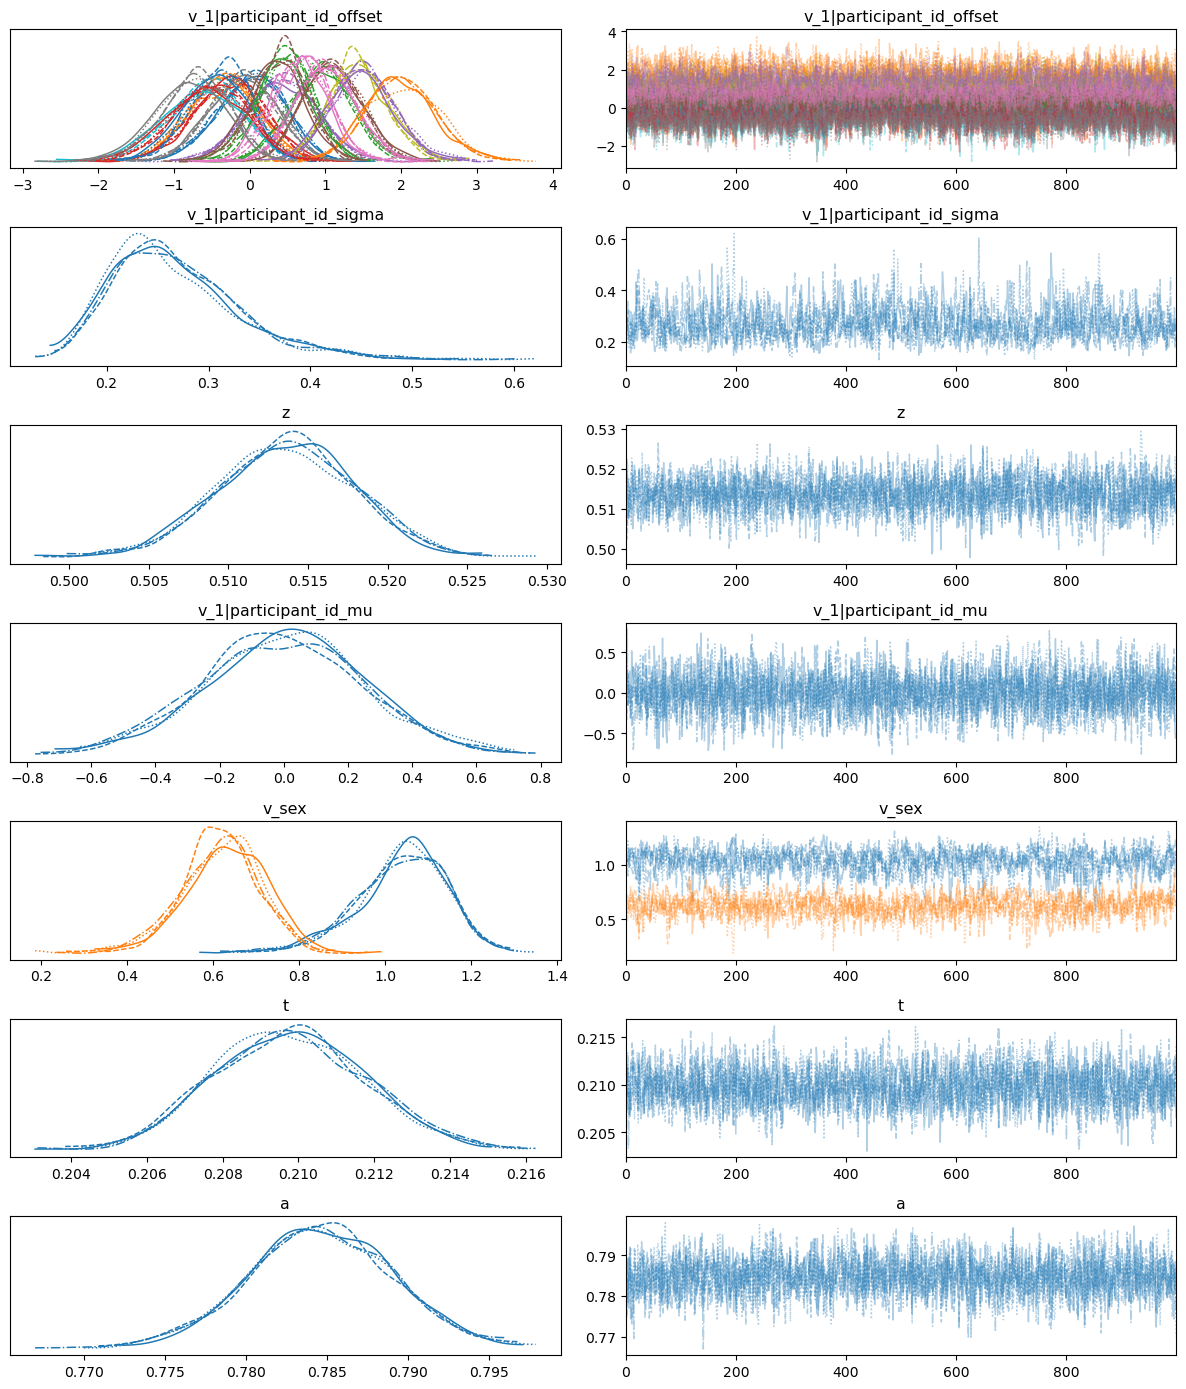

In [18]:
 v_sex.plot_trace()

Next, we want to check our fits to the observed data. Below, we show how to do that. We are plotting the predicted posterior versus the observed data. 

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


''

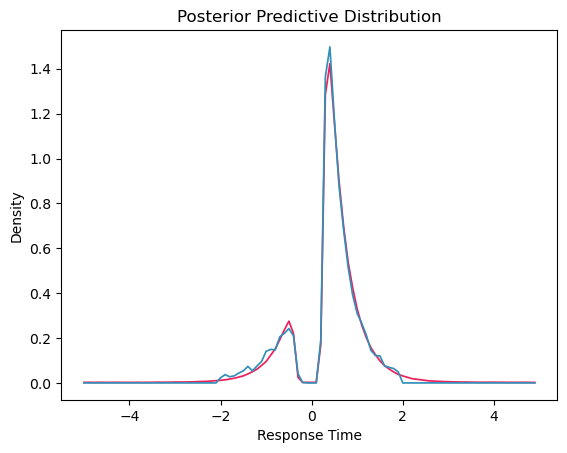

In [ ]:
hssm.plotting.plot_posterior_predictive(
    v_sex, # the model which you have fit
    range=(-5,5) # the range on the x-axis, which is the response time
)
;

We can also look at fits to individual subjects. Below is an example on how to do that.

#### Example of a good fit:

''

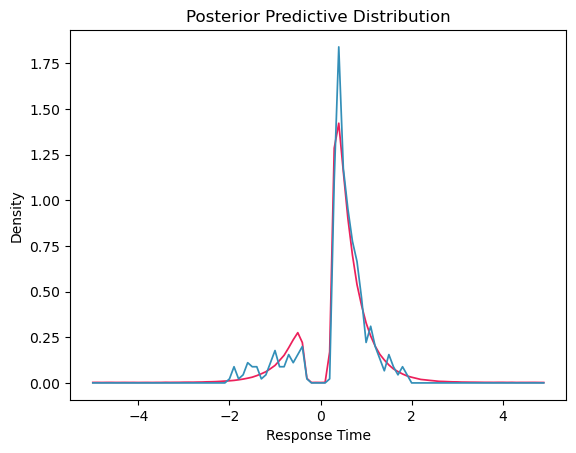

In [ ]:
hssm.plotting.plot_posterior_predictive(
    v_sex, # the model which you have fit
    data = df[df.participant_id=='BG04'], # specifying a specific subject
    range=(-5,5) # the range on the x-axis, which is the response time
)
;

#### Example of a bad fit: 

''

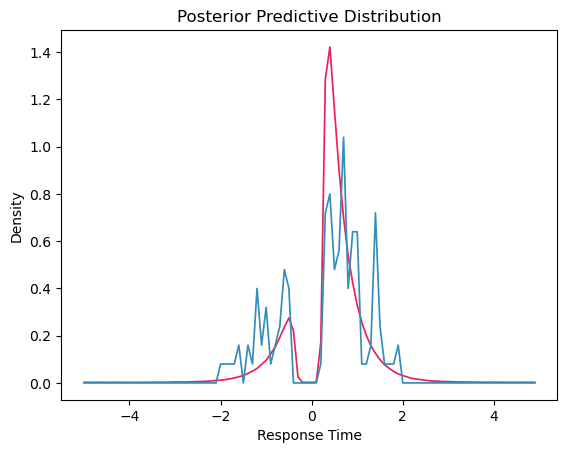

In [ ]:
hssm.plotting.plot_posterior_predictive(
    v_sex, # the model which you have fit
    data = df[df.participant_id=='JK03'], # specifying a specific subject
    range=(-5,5) # the range on the x-axis, which is the response time
)
;

If you want to look at fits for all participants, the below cell could do so - for now it is commented out.

#### Back to the stats: HDI

**"hdi_3%" and "hdi_97%" - indicate the 94% HDI (Highest Density Interval)**

-  HDI expresses the certainty in Bayesian fits. It refers to the interval within the posterior distribution that is most concentrated, and therefore contains the most probable values of the parameter.

In [ ]:
az.summary(v_sex.traces, var_names=['v_sex','t','z','a'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_sex[F],1.058,0.109,0.840,1.237,0.004,0.003,893.0,1327.0,1.01
v_sex[M],0.639,0.096,0.447,0.804,0.003,0.002,982.0,1529.0,1.00
t,0.213,0.002,0.208,0.217,0.000,0.000,2177.0,2581.0,1.00
z,0.513,0.005,0.505,0.522,0.000,0.000,2676.0,2676.0,1.00
a,0.780,0.005,0.771,0.788,0.000,0.000,2523.0,2529.0,1.00


''

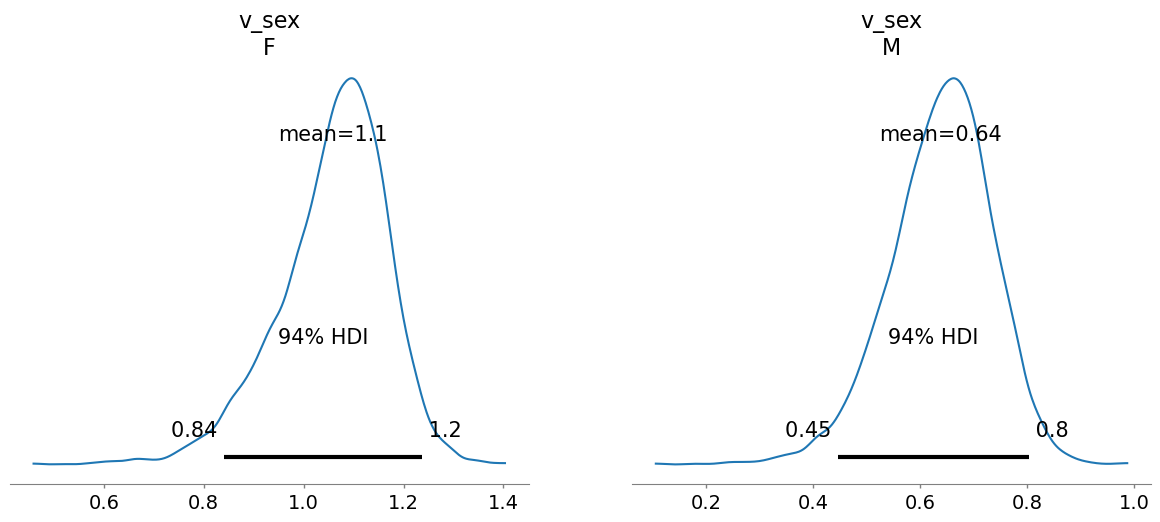

In [ ]:
az.plot_posterior(v_sex.traces, var_names=('v_sex')) # the default is 94% HDI. you can use hdi_prob to change it to a different interval, for example hdi_prob=0.95

''

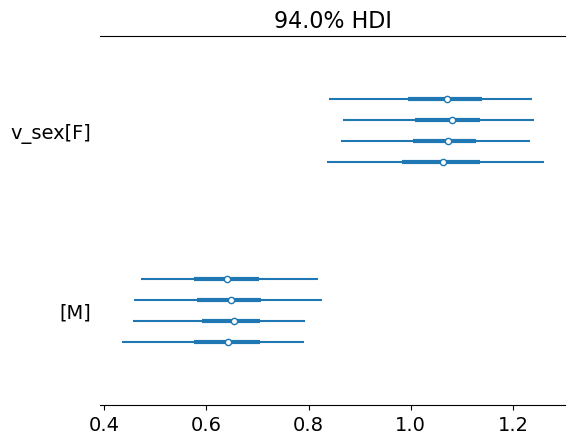

In [ ]:
az.plot_forest(v_sex.traces, var_names=('v_sex')) # here, we can visualize the HDI for males and females from each of the 4 chains we sampled from

''

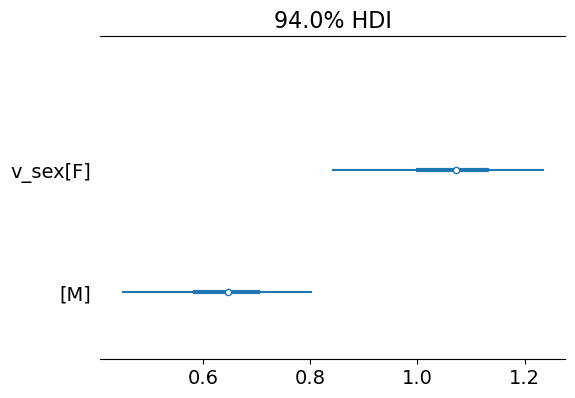

In [ ]:
az.plot_forest(v_sex.traces, var_names=('v_sex'), combined=True) # same as above, just combining all 4 chains into a single chain

In [ ]:
v_sex_stats = v_sex.summary() # saving our stats table as a dataframe for more flexibility in visualization of HDI
v_sex_stats.head()

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
v_sex[F],1.058,0.109,0.840,1.237,0.004,0.003,893.0,1327.0,1.01
v_sex[M],0.639,0.096,0.447,0.804,0.003,0.002,982.0,1529.0,1.00
v_1|participant_id_mu,0.012,0.251,-0.471,0.476,0.004,0.004,3235.0,2692.0,1.00
t,0.213,0.002,0.208,0.217,0.000,0.000,2177.0,2581.0,1.00
z,0.513,0.005,0.505,0.522,0.000,0.000,2676.0,2676.0,1.00


''

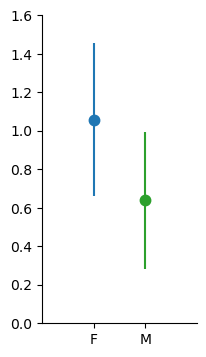

In [ ]:
plt.figure(figsize=(2,4))

plt.errorbar([0],v_sex_stats['mean'].loc['v_sex[F]'], 
             yerr=v_sex_stats['hdi_97%'].loc['v_sex[F]']-v_sex_stats['hdi_3%'].loc['v_sex[F]'], 
              marker='o',mew=2.5, ls='',color='C0')

plt.errorbar([1],v_sex_stats['mean'].loc['v_sex[M]'], 
             yerr=v_sex_stats['hdi_97%'].loc['v_sex[M]']-v_sex_stats['hdi_3%'].loc['v_sex[M]'], 
              marker='o',mew=2.5, ls='',color='C2')

plt.ylim(0,1.6)
plt.xlim(-1,2)

x = [0,1]
labels = ['F','M']
plt.xticks(x,labels)

sns.despine()

### Interpretations:

Females have a greater drift rate than males. This means that females integrated sensory information about the stimuli faster than males. When linked back to our behavioral effects, this can explain why females chose the higher-value cue more frequently than males.

## EXAMPLE 2: Effects of sex AND session on threshold.

#### Our approach here will be the exact same as in Example 1, only now we will look at interaction effects of sex and session. 

In [ ]:
a_interaction = hssm.HSSM(
    model="ddm",
    data=df,
    prior_settings="safe",
    include=[
        {   "name": "a",
            "formula": "a ~ sex*sess + (1|participant_id)", # note the 0 after ~ was removed. this is the default set up (could also replace the 0 with a 1).
        }
    ],
)

In [ ]:
a_interaction.sample(target_accept=0.9)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [t, v, z, a_Intercept, a_sex, a_sess, a_sex:sess, a_1|participant_id_sigma, a_1|participant_id_offset]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2880 seconds.


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [ ]:
az.summary(a_interaction.traces, var_names=['a_sex','a_sess','t','z','v'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a_sex[M],0.104,0.052,0.008,0.208,0.001,0.001,1309.0,1706.0,1.0
a_sess[2],-0.006,0.016,-0.035,0.024,0.000,0.000,2970.0,2802.0,1.0
a_sess[3],-0.003,0.016,-0.031,0.027,0.000,0.000,2903.0,2752.0,1.0
a_sess[4],-0.025,0.015,-0.052,0.003,0.000,0.000,2597.0,3033.0,1.0
a_sess[5],-0.010,0.015,-0.039,0.017,0.000,0.000,3018.0,2869.0,1.0
t,0.225,0.002,0.222,0.228,0.000,0.000,4266.0,3069.0,1.0
z,0.517,0.004,0.509,0.525,0.000,0.000,3449.0,2443.0,1.0
v,0.971,0.020,0.934,1.011,0.000,0.000,3915.0,2837.0,1.0


### Checking traces & posteriors.

-  We can see in the posteriors that fits are no longer estimated for each level (because we removed the 0 in our formula above). 

-  There is a single estimate for sex (which has 2 levels), and four for sessions (which has 5 levels). This is because one level from each category serves as a "reference" for all others. In this case, females and session 1 are the reference levels.

-  The interpretation of the sex posterior (a_sex) is a bit different now that we have an interaction in our model. Since the reference level is females in session 1, we are looking at the posterior of males compared to females when session is 1. This distribution is barely overlapping with zero, meaning there is likely a slight offset by sex in session 1. Referring to the summary table above, we can see the HDI does not contain zero, so the most probable threshold for males is *slightly* greater than that of females in session 1.

-  The same goes for interpreting the session posteriors (a_sess). We are looking at the posteriors of sessions 2-5 compared to session 1 when sex is female. They are all roughly overlapping, and all HDI's contain zero. This means that females did not have a change in threshold over sessions.

The important fit to note here is the interaction between sex and session (a_sex:sess). Here, we are looking at posteriors of males in sessions 2-5, each compared to females in session 1. This reveals the interaction effect, where males have a reduction in threshold over sessions (specifcally sessions 4 and 5, which are depicted in green and red). 

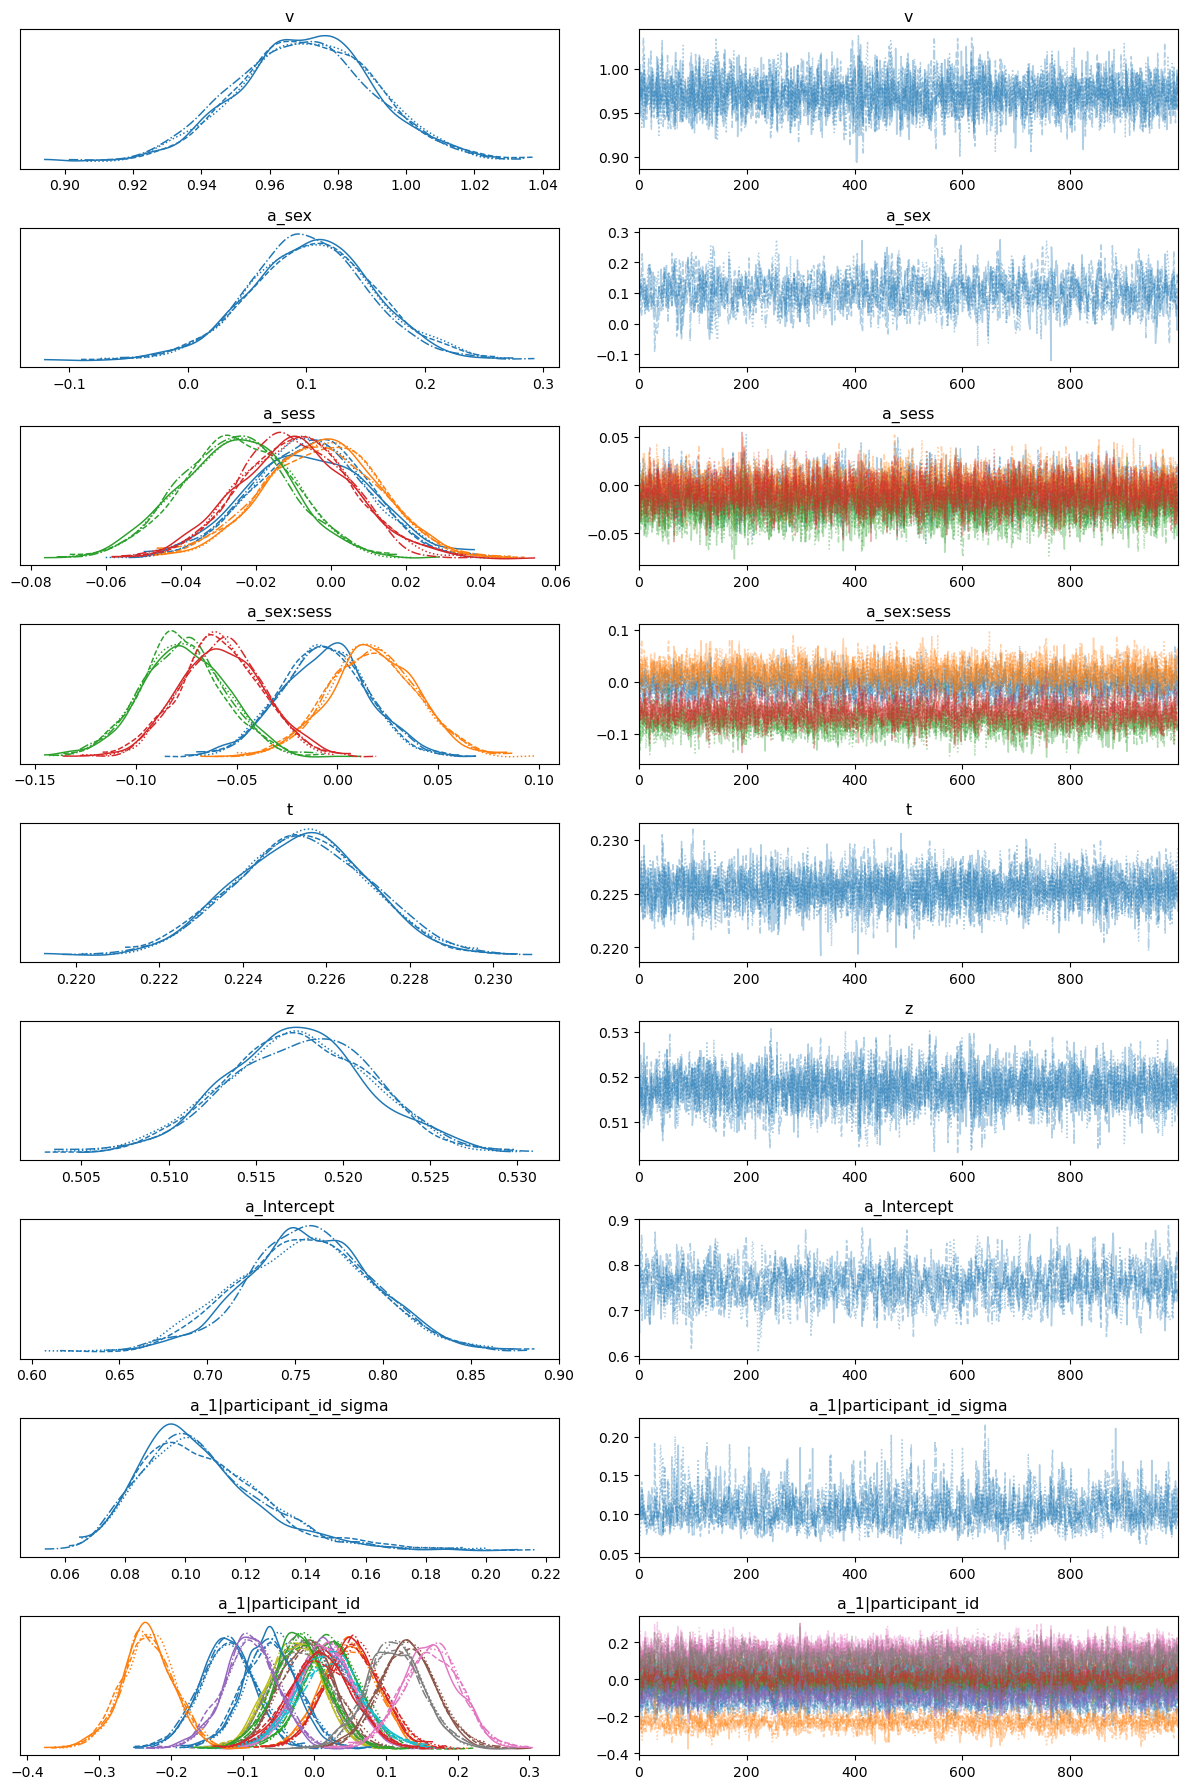

In [ ]:
a_interaction.plot_trace()

### Checking fits to RT.

#### Global:

No posterior predictive samples found. Generating posterior predictive samples using the provided InferenceData object and the original data. This will modify the provided InferenceData object, or if not provided, the traces object stored inside the model.


''

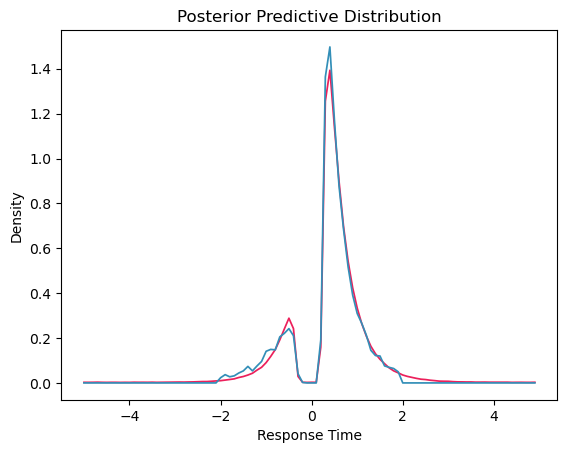

In [ ]:
hssm.plotting.plot_posterior_predictive(
    a_interaction, # the model which you have fit
    range=(-5,5) # the range on the x-axis, which is the response time
)

#### Example of a good fit.

''

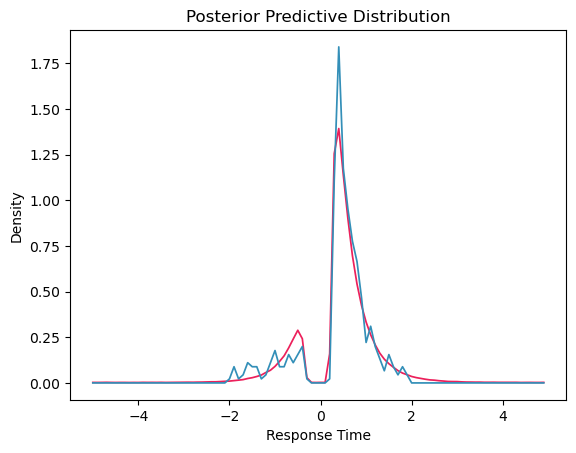

In [ ]:
hssm.plotting.plot_posterior_predictive(
    a_interaction, # the model which you have fit
    data = df[df.participant_id=='BG04'], # specifying a specific subject
    range=(-5,5) # the range on the x-axis, which is the response time
)

#### Example of a bad fit.

''

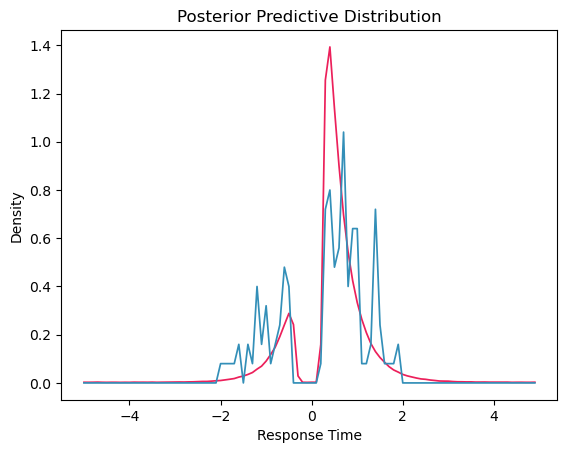

In [ ]:
hssm.plotting.plot_posterior_predictive(
    a_interaction, # the model which you have fit
    data = df[df.participant_id=='JK03'], # specifying a specific subject
    range=(-5,5) # the range on the x-axis, which is the response time
)
;

#### Uncomment the below cell to look at fits to all participants:

#### HDI

''

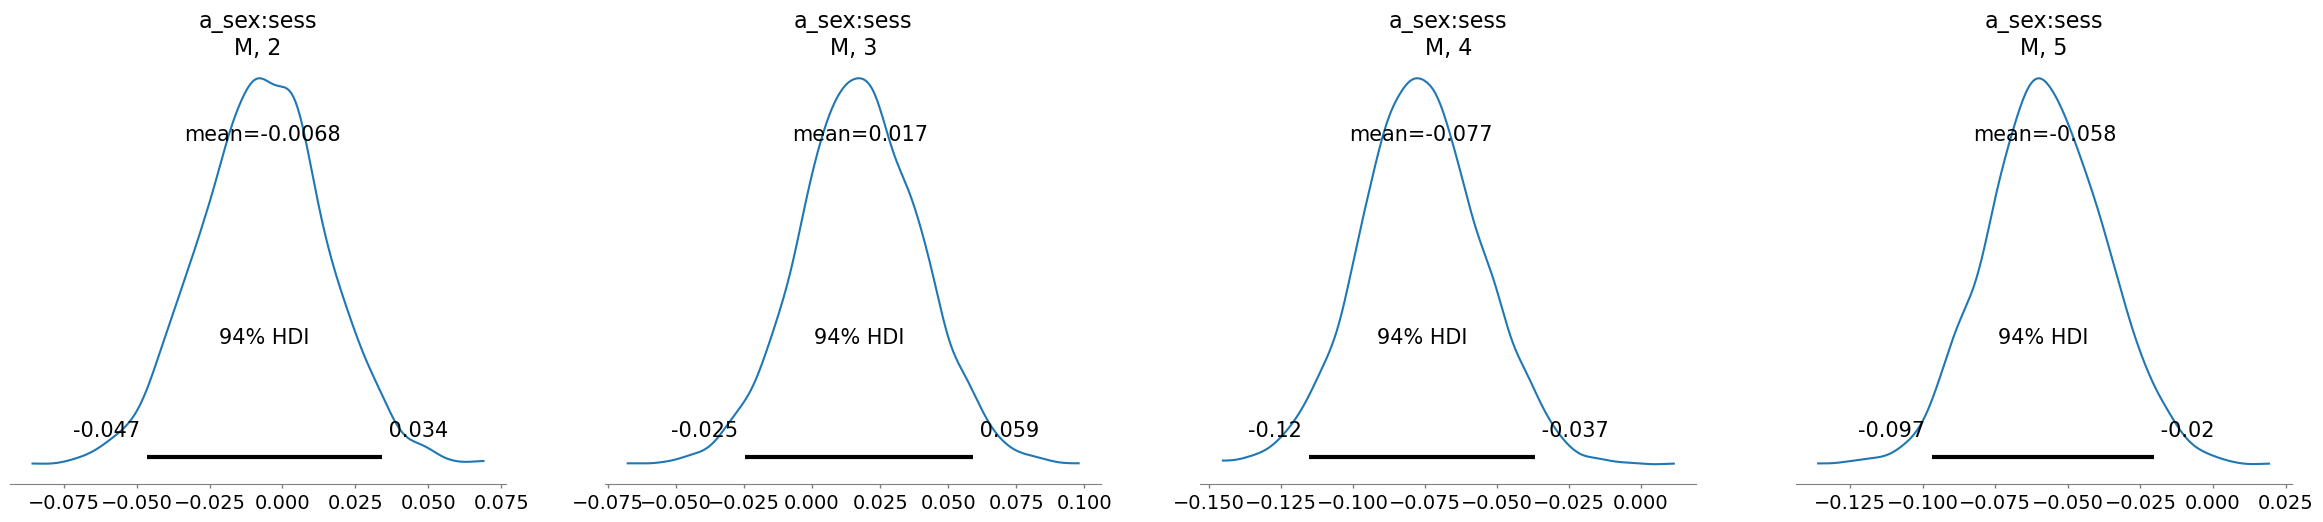

In [ ]:
az.plot_posterior(a_interaction.traces, var_names=('a_sex:sess'))

''

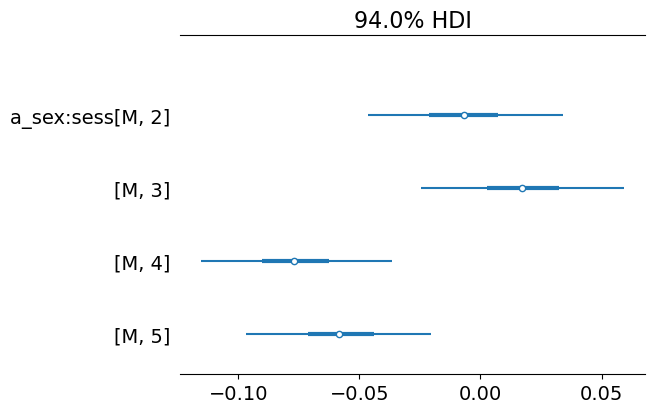

In [ ]:
az.plot_forest(a_interaction.traces, var_names=('a_sex:sess'),combined=True)

In [ ]:
a_interaction_stats = a_interaction.summary()

''

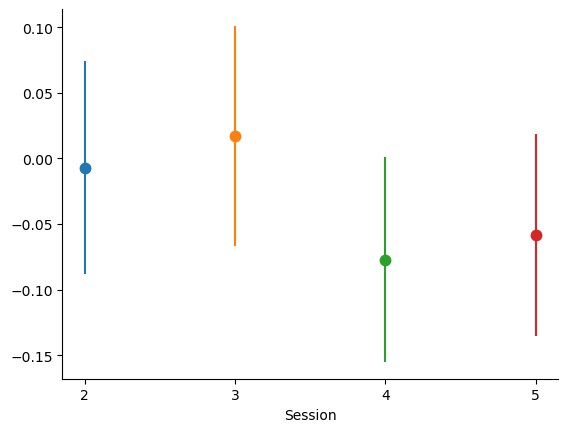

In [ ]:
plt.errorbar([0],a_interaction_stats['mean'].loc['a_sex:sess[M, 2]'], 
             yerr=a_interaction_stats['hdi_97%'].loc['a_sex:sess[M, 2]']-a_interaction_stats['hdi_3%'].loc['a_sex:sess[M, 2]'], 
              marker='o',mew=2.5, ls='',color='C0')

plt.errorbar([1],a_interaction_stats['mean'].loc['a_sex:sess[M, 3]'], 
             yerr=a_interaction_stats['hdi_97%'].loc['a_sex:sess[M, 3]']-a_interaction_stats['hdi_3%'].loc['a_sex:sess[M, 3]'], 
              marker='o',mew=2.5, ls='',color='C1')

plt.errorbar([2],a_interaction_stats['mean'].loc['a_sex:sess[M, 4]'], 
             yerr=a_interaction_stats['hdi_97%'].loc['a_sex:sess[M, 4]']-a_interaction_stats['hdi_3%'].loc['a_sex:sess[M, 4]'], 
              marker='o',mew=2.5, ls='',color='C2')

plt.errorbar([3],a_interaction_stats['mean'].loc['a_sex:sess[M, 5]'], 
             yerr=a_interaction_stats['hdi_97%'].loc['a_sex:sess[M, 5]']-a_interaction_stats['hdi_3%'].loc['a_sex:sess[M, 5]'], 
              marker='o',mew=2.5, ls='',color='C3')

sns.despine()
labels = (2,3,4,5)
x = [0,1,2,3]
plt.xticks(x,labels)
plt.xlabel('Session')

#### Interpretations:

Males have a reduction in threshold over sessions (specifically, sessions 4 and 5), and females do not. This indicates that with learning, males required less information/evidence to make their choice. If we think back to the behavior, this aligns well with the reduction in response latencies over sessions that males demonstrated.

Taken together with the effects on drift rate, one interpretation of these results is a reflection of males being more choice impulsive than females - they begin to require less information to make a choice, yet consistently choose the worse option more frequently than females do.

### Now you're ready to use HSSM with your own behavioral data!